# Pré-processamento dos dados

## Declaração de bibliotecas e funções

In [9]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import scipy.io as sio

sns.set_context("talk")

In [12]:
data_path = '../data/detected_signals/'

In [3]:
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    # Function by hitvoice
    # https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
    y_true:    true label of the data, with shape (nsamples,)
    y_pred:    prediction of the data, with shape (nsamples,)
    filename:  filename of figure file to save
    labels:    string array, name the order of class labels in the confusion matrix.
                use `clf.classes_` if using scikit-learn models.
                with shape (nclass,).
    ymap:      dict: any -> string, length == nclass.
                if not None, map the labels & ys to more understandable strings.
                Caution: original y_true, y_pred and labels must align.
    figsize:   the size of the figure plotted.
    """
    sns.set_context("notebook")
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Real'
    cm.columns.name = 'Predito'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='Greys')
    plt.savefig(filename, dpi=300)


In [13]:
fileNames = np.array((os.listdir(data_path)))
print(fileNames)

BT_150_90_100.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_BC_20_150_1.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_ABT_150_110_50.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_BT_150_130_1.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_CAT_150_40_100.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_CA_150_10_100.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_BT_150_60_1.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_CA_150_0_50.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_ABC_150_150_1.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_CAT_150_90_1.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_ABC_150_100_100.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_ABC_150_70_50.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_AB_20_110_1.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_CA_20_110_1.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_CAT_150_10_1.0000.mat'
 'detected_sim_Chesf_500_Classifier_LOC3_ABT_150_180_1.0000.mat'
 'detected

In [14]:
teste_data = mat = sio.loadmat(data_path + fileNames[0])

In [15]:
teste_data['sinal_notch_final'].shape

(320, 3)

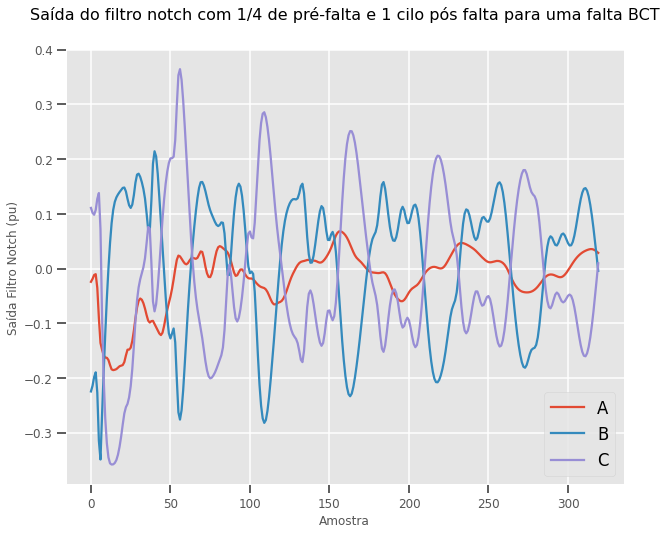

In [24]:
plt.style.use('ggplot')
fig= plt.figure(figsize=(10,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.axes()
sns.lineplot(data=teste_data['sinal_notch_final'][:,0])
sns.lineplot(data=teste_data['sinal_notch_final'][:,1])
sns.lineplot(data=teste_data['sinal_notch_final'][:,2])
ax.set_title(f'Saída do filtro notch com 1/4 de pré-falta e 1 cilo pós falta para uma falta {teste_data["faultType"][0]}', fontsize=16, pad=30)
ax.set_ylabel(f'Saída Filtro Notch (pu)')
ax.set_xlabel(f'Amostra')
plt.legend(loc='lower right', labels=['A', 'B', 'C'])
plt.show()

In [25]:
teste_data['faultType'][0]

'BCT'

In [0]:
def join_signal(n, data):
    final_data = []
    final_class = []
    # 1 ciclo pós falta
    if n == 1:
        for item in data:
            final_data.append(np.hstack([item['sinal_notch_final'][:,0], item['sinal_notch_final'][:,1], item['sinal_notch_final'][:,2]]))
            final_class.append(item['faultType'][0])

    # 1/2 ciclo pós falta
    if n == 2:
        for item in data:
            final_data.append(np.hstack([item['sinal_notch_final'][:192,0], item['sinal_notch_final'][:192,1], item['sinal_notch_final'][:192,2]]))
            final_class.append(item['faultType'][0])

    # 1/4 ciclo pós falta
    if n == 4:
        for item in data:
            final_data.append(np.hstack([item['sinal_notch_final'][:128,0], item['sinal_notch_final'][:128,1], item['sinal_notch_final'][:128,2]]))
            final_class.append(item['faultType'][0])
    
    # 1/8 ciclo pós falta
    if n == 8:
        for item in data:
            final_data.append(np.hstack([item['sinal_notch_final'][:96,0], item['sinal_notch_final'][:96,1], item['sinal_notch_final'][:96,2]]))
            final_class.append(item['faultType'][0])

    # 1/16 ciclo pós falta
    if n == 16:
        for item in data:
            final_data.append(np.hstack([item['sinal_notch_final'][:80,0], item['sinal_notch_final'][:80,1], item['sinal_notch_final'][:80,2]]))
            final_class.append(item['faultType'][0])
    
    # 1/32 ciclo pós falta
    if n == 32:
        for item in data:
            final_data.append(np.hstack([item['sinal_notch_final'][:72,0], item['sinal_notch_final'][:72,1], item['sinal_notch_final'][:72,2]]))
            final_class.append(item['faultType'][0])

    df = pd.DataFrame(np.row_stack(final_data))
    df = pd.concat([df, pd.Series(final_class)], axis=1)
    return df

In [0]:
data_1_ciclo = join_signal(1, data)
data_1_2_ciclo = join_signal(2, data)
data_1_4_ciclo = join_signal(4, data)
data_1_8_ciclo = join_signal(8, data)
data_1_16_ciclo = join_signal(16, data)
data_1_32_ciclo = join_signal(32, data)

In [10]:
data_1_ciclo.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,0
0,-0.090658,-0.088706,-0.086457,-0.081299,-0.062102,-0.016118,0.017655,-0.025869,-0.062621,-0.093731,-0.120123,-0.142567,-0.161722,-0.178180,-0.192385,-0.204534,-0.214780,-0.22353,-0.232093,-0.245539,-0.274151,-0.315982,-0.329688,-0.290460,-0.256377,-0.226666,-0.200667,-0.177814,-0.157631,-0.139713,-0.123710,-0.109335,-0.096364,-0.084612,-0.073943,-0.064281,-0.055501,-0.047194,-0.038867,-0.030948,...,0.000106,0.000107,0.000105,0.000100,0.000092,0.000082,0.000073,0.000065,0.000058,0.000053,0.000049,0.000045,0.000039,0.000034,0.000030,0.000025,0.000020,0.000014,0.000006,-0.000004,-0.000014,-0.000023,-0.000030,-0.000034,-0.000035,-0.000035,-0.000034,-0.000033,-0.000031,-0.000028,-0.000024,-0.000021,-0.000020,-0.000021,-0.000026,-0.000031,-0.000036,-0.000039,-0.000040,AB
1,0.420833,0.412714,0.404462,0.396097,0.387638,0.379104,0.370511,0.361876,0.353213,0.344538,0.335865,0.327204,0.318570,0.309972,0.301422,0.292928,0.284502,0.27615,0.267880,0.259700,0.251617,0.243637,0.235765,0.228007,0.220367,0.212851,0.205462,0.198204,0.191079,0.184091,0.177242,0.170535,0.163970,0.157549,0.151273,0.145143,0.139159,0.133322,0.127632,0.122088,...,0.001488,0.002239,0.002729,0.002711,0.002019,0.000675,-0.001022,-0.002545,-0.003374,-0.003276,-0.002430,-0.001308,-0.000409,-0.000029,-0.000185,-0.000680,-0.001237,-0.001598,-0.001569,-0.001033,-0.000002,0.001326,0.002561,0.003253,0.003121,0.002227,0.000956,-0.000192,-0.000848,-0.000915,-0.000543,-0.000013,0.000406,0.000520,0.000237,-0.000434,-0.001358,-0.002257,-0.002777,BC
2,-0.431107,-0.419239,-0.421569,-0.424617,-0.423574,-0.435672,-0.458743,-0.463333,-0.438503,-0.390312,-0.333078,-0.301631,-0.288247,-0.285665,-0.291154,-0.301723,-0.315776,-0.32999,-0.340242,-0.346420,-0.350643,-0.351203,-0.348659,-0.352122,-0.365515,-0.378601,-0.386025,-0.385709,-0.358352,-0.296446,-0.241899,-0.226272,-0.215522,-0.191304,-0.171529,-0.153371,-0.124533,-0.098609,-0.091925,-0.097254,...,-0.254739,-0.254193,-0.246385,-0.233647,-0.219430,-0.206675,-0.197119,-0.191142,-0.187811,-0.185229,-0.181132,-0.173585,-0.161667,-0.145719,-0.126699,-0.105138,-0.080924,-0.054092,-0.025548,0.003127,0.030432,0.055378,0.077396,0.096216,0.112131,0.126255,0.140085,0.154395,0.168472,0.180547,0.189028,0.193395,0.194098,0.191741,0.186462,0.178118,0.167034,0.154433,0.142073,CT
3,0.116064,0.099360,0.083494,0.068444,0.054182,0.040683,0.027921,0.015872,0.004496,-0.006287,-0.016501,-0.025915,-0.034700,-0.042889,-0.050509,-0.057588,-0.064150,-0.07022,-0.075820,-0.080969,-0.085690,-0.090003,-0.093995,-0.098356,-0.106133,-0.121842,-0.138353,-0.137986,-0.133580,-0.126116,-0.116381,-0.105004,-0.092477,-0.079178,-0.065406,-0.051438,-0.037506,-0.023739,-0.009978,0.005009,...,-0.108046,-0.128514,-0.132318,-0.124021,-0.115235,-0.116313,-0.132152,-0.162247,-0.202345,-0.246275,-0.287483,-0.320155,-0.339899,-0.344039,-0.331606,-0.303181,-0.260662,-0.206915,-0.145286,-0.079142,-0.011630,0.054422,0.116664,0.173421,0.223686,0.266755,0.301565,0.326100,0.337776,0.335555,0.322841,0.308036,0.300211,0.302163,0.307282,0.303814,0.282589,0.241546,0.185085,ABC
4,-0.116195,-0.099485,-0.083613,-0.068556,-0.054289,-0.040785,-0.028018,-0.015964,-0.004584,0.006202,0.016419,0.025836,0.034624,0.042815,0.050438,0.057520,0.064086,0.07016,0.075764,0.080920,0.085646,0.089967,0.093967,0.098334,0.106110,0.121801,0.138308,0.137992,0.133627,0.126195,0.116484,0.105125,0.092612,0.079321,0.065555,0.051589,0.037656,0.023884,0.010118,-0.004872,...,0.108088,0.128557,0.132359,0.124060,0.115270,0.116346,0.132182,0.162278,0.202377,0.246308,0.287517,0.320190,0.339934,0.344072,0.331636,0.303206,0.260681,0.206927,0.145290,0.079137,0.011615,-0.054446,-0.116697,-0.173462,-0.223734,-0.266810,-0.301625,-0.326164,-0.337842,-0.335621,-0.

In [11]:
data_1_2_ciclo.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,0
0,-0.090658,-0.088706,-0.086457,-0.081299,-0.062102,-0.016118,0.017655,-0.025869,-0.062621,-0.093731,-0.120123,-0.142567,-0.161722,-0.178180,-0.192385,-0.204534,-0.214780,-0.22353,-0.232093,-0.245539,-0.274151,-0.315982,-0.329688,-0.290460,-0.256377,-0.226666,-0.200667,-0.177814,-0.157631,-0.139713,-0.123710,-0.109335,-0.096364,-0.084612,-0.073943,-0.064281,-0.055501,-0.047194,-0.038867,-0.030948,...,-0.002726,-0.002670,-0.002615,-0.002557,-0.002496,-0.002431,-0.002364,-0.002295,-0.002227,-0.002159,-0.002093,-0.002027,-0.001960,-0.001894,-0.001831,-0.001773,-0.001720,-0.001669,-0.001617,-0.001562,-0.001504,-0.001445,-0.001385,-0.001326,-0.001268,-0.001211,-0.001153,-0.001095,-0.001038,-0.000984,-0.000936,-0.000895,-0.000857,-0.000820,-0.000781,-0.000740,-0.000699,-0.000658,-0.000620,AB
1,0.420833,0.412714,0.404462,0.396097,0.387638,0.379104,0.370511,0.361876,0.353213,0.344538,0.335865,0.327204,0.318570,0.309972,0.301422,0.292928,0.284502,0.27615,0.267880,0.259700,0.251617,0.243637,0.235765,0.228007,0.220367,0.212851,0.205462,0.198204,0.191079,0.184091,0.177242,0.170535,0.163970,0.157549,0.151273,0.145143,0.139159,0.133322,0.127632,0.122088,...,0.012362,0.009438,0.005513,0.001213,-0.002499,-0.004547,-0.004368,-0.002473,-0.000287,0.000748,0.000064,-0.001845,-0.003903,-0.005098,-0.004877,-0.003209,-0.000421,0.003007,0.006511,0.009391,0.010846,0.010294,0.007873,0.004607,0.001919,0.000761,0.001092,0.002071,0.002668,0.002208,0.000565,-0.001946,-0.004812,-0.007505,-0.009510,-0.010301,-0.009443,-0.006913,-0.003381,BC
2,-0.431107,-0.419239,-0.421569,-0.424617,-0.423574,-0.435672,-0.458743,-0.463333,-0.438503,-0.390312,-0.333078,-0.301631,-0.288247,-0.285665,-0.291154,-0.301723,-0.315776,-0.32999,-0.340242,-0.346420,-0.350643,-0.351203,-0.348659,-0.352122,-0.365515,-0.378601,-0.386025,-0.385709,-0.358352,-0.296446,-0.241899,-0.226272,-0.215522,-0.191304,-0.171529,-0.153371,-0.124533,-0.098609,-0.091925,-0.097254,...,-0.023093,-0.006551,0.010750,0.033867,0.064202,0.101768,0.145995,0.192297,0.232287,0.260148,0.275787,0.281438,0.278697,0.268630,0.251772,0.228296,0.200110,0.172103,0.149717,0.135407,0.128087,0.125750,0.127675,0.133139,0.138706,0.139132,0.132091,0.121079,0.112600,0.110515,0.113586,0.117674,0.119100,0.116461,0.110350,0.101692,0.090540,0.076260,0.057916,CT
3,0.116064,0.099360,0.083494,0.068444,0.054182,0.040683,0.027921,0.015872,0.004496,-0.006287,-0.016501,-0.025915,-0.034700,-0.042889,-0.050509,-0.057588,-0.064150,-0.07022,-0.075820,-0.080969,-0.085690,-0.090003,-0.093995,-0.098356,-0.106133,-0.121842,-0.138353,-0.137986,-0.133580,-0.126116,-0.116381,-0.105004,-0.092477,-0.079178,-0.065406,-0.051438,-0.037506,-0.023739,-0.009978,0.005009,...,0.210422,0.150678,0.094229,0.040706,-0.008972,-0.053240,-0.091470,-0.123777,-0.150470,-0.171590,-0.186905,-0.197001,-0.205751,-0.221739,-0.252678,-0.291427,-0.309340,-0.277763,-0.201937,-0.119361,-0.062519,-0.040825,-0.050711,-0.083069,-0.128040,-0.177510,-0.225367,-0.265770,-0.290802,-0.291040,-0.263022,-0.220162,-0.191305,-0.197029,-0.226529,-0.247810,-0.237916,-0.193084,-0.119772,ABC
4,-0.116195,-0.099485,-0.083613,-0.068556,-0.054289,-0.040785,-0.028018,-0.015964,-0.004584,0.006202,0.016419,0.025836,0.034624,0.042815,0.050438,0.057520,0.064086,0.07016,0.075764,0.080920,0.085646,0.089967,0.093967,0.098334,0.106110,0.121801,0.138308,0.137992,0.133627,0.126195,0.116484,0.105125,0.092612,0.079321,0.065555,0.051589,0.037656,0.023884,0.010118,-0.004872,...,-0.210458,-0.150703,-0.094243,-0.040709,0.008980,0.053258,0.091496,0.123812,0.150512,0.171638,0.186958,0.197057,0.205811,0.221801,0.252744,0.291497,0.309411,0.277830,0.201996,0.119409,0.062558,0.040858,0.050741,0.083097,0.128068,0.177539,0.225396,0.265800,0.290831,0.2910

In [12]:
data_1_4_ciclo.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,0
0,-0.090658,-0.088706,-0.086457,-0.081299,-0.062102,-0.016118,0.017655,-0.025869,-0.062621,-0.093731,-0.120123,-0.142567,-0.161722,-0.178180,-0.192385,-0.204534,-0.214780,-0.22353,-0.232093,-0.245539,-0.274151,-0.315982,-0.329688,-0.290460,-0.256377,-0.226666,-0.200667,-0.177814,-0.157631,-0.139713,-0.123710,-0.109335,-0.096364,-0.084612,-0.073943,-0.064281,-0.055501,-0.047194,-0.038867,-0.030948,...,0.005838,0.005234,0.004655,0.004097,0.003563,0.003054,0.002569,0.002110,0.001676,0.001266,0.000878,0.000511,0.000163,-0.000159,-0.000454,-0.000725,-0.000980,-0.001224,-0.001456,-0.001675,-0.001881,-0.002070,-0.002244,-0.002404,-0.002552,-0.002689,-0.002817,-0.002935,-0.003042,-0.003132,-0.003208,-0.003274,-0.003337,-0.003396,-0.003452,-0.003501,-0.003542,-0.003573,-0.003596,AB
1,0.420833,0.412714,0.404462,0.396097,0.387638,0.379104,0.370511,0.361876,0.353213,0.344538,0.335865,0.327204,0.318570,0.309972,0.301422,0.292928,0.284502,0.27615,0.267880,0.259700,0.251617,0.243637,0.235765,0.228007,0.220367,0.212851,0.205462,0.198204,0.191079,0.184091,0.177242,0.170535,0.163970,0.157549,0.151273,0.145143,0.139159,0.133322,0.127632,0.122088,...,-0.008576,-0.000249,0.007553,0.013507,0.016236,0.015332,0.012287,0.009951,0.010511,0.013900,0.018161,0.021018,0.021084,0.018163,0.012952,0.006531,-0.000033,-0.005835,-0.010045,-0.011888,-0.010986,-0.007975,-0.004645,-0.003002,-0.003796,-0.005965,-0.007538,-0.007006,-0.004015,0.000771,0.006197,0.011132,0.014745,0.016498,0.016020,0.013148,0.008293,0.002781,-0.001482,BC
2,-0.431107,-0.419239,-0.421569,-0.424617,-0.423574,-0.435672,-0.458743,-0.463333,-0.438503,-0.390312,-0.333078,-0.301631,-0.288247,-0.285665,-0.291154,-0.301723,-0.315776,-0.32999,-0.340242,-0.346420,-0.350643,-0.351203,-0.348659,-0.352122,-0.365515,-0.378601,-0.386025,-0.385709,-0.358352,-0.296446,-0.241899,-0.226272,-0.215522,-0.191304,-0.171529,-0.153371,-0.124533,-0.098609,-0.091925,-0.097254,...,0.165502,0.181468,0.190804,0.203536,0.222667,0.243927,0.261116,0.269710,0.265244,0.243683,0.209737,0.175603,0.150271,0.135430,0.127836,0.122675,0.117217,0.112373,0.110600,0.112114,0.113313,0.109911,0.101958,0.095317,0.094588,0.093012,0.078882,0.054753,0.036340,0.031774,0.035505,0.038714,0.033866,0.014904,-0.018042,-0.058642,-0.101156,-0.142195,-0.177830,CT
3,0.116064,0.099360,0.083494,0.068444,0.054182,0.040683,0.027921,0.015872,0.004496,-0.006287,-0.016501,-0.025915,-0.034700,-0.042889,-0.050509,-0.057588,-0.064150,-0.07022,-0.075820,-0.080969,-0.085690,-0.090003,-0.093995,-0.098356,-0.106133,-0.121842,-0.138353,-0.137986,-0.133580,-0.126116,-0.116381,-0.105004,-0.092477,-0.079178,-0.065406,-0.051438,-0.037506,-0.023739,-0.009978,0.005009,...,0.384694,0.533395,0.671057,0.715089,0.695291,0.634753,0.550697,0.455516,0.357792,0.263169,0.175097,0.095469,0.025129,-0.035715,-0.087028,-0.128796,-0.161826,-0.188631,-0.211629,-0.230097,-0.242204,-0.248665,-0.250821,-0.249888,-0.246773,-0.242241,-0.237428,-0.234551,-0.236390,-0.241267,-0.233835,-0.186992,-0.094739,-0.006561,0.011235,-0.043766,-0.124576,-0.202445,-0.262073,ABC
4,-0.116195,-0.099485,-0.083613,-0.068556,-0.054289,-0.040785,-0.028018,-0.015964,-0.004584,0.006202,0.016419,0.025836,0.034624,0.042815,0.050438,0.057520,0.064086,0.07016,0.075764,0.080920,0.085646,0.089967,0.093967,0.098334,0.106110,0.121801,0.138308,0.137992,0.133627,0.126195,0.116484,0.105125,0.092612,0.079321,0.065555,0.051589,0.037656,0.023884,0.010118,-0.004872,...,-0.384763,-0.533478,-0.671152,-0.715188,-0.695387,-0.634842,-0.550776,-0.455583,-0.357844,-0.263208,-0.175122,-0.095480,-0.025127,0.035729,0.087053,0.128831,0.161870,0.188682,0.211687,0.230159,0.242271,0.248734,0.250892,0.249959,0.246843,0.242310,0.237494,0.234614,0.236450,0.241324,0.233888,0.

In [13]:
data_1_8_ciclo.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,0
0,-0.090658,-0.088706,-0.086457,-0.081299,-0.062102,-0.016118,0.017655,-0.025869,-0.062621,-0.093731,-0.120123,-0.142567,-0.161722,-0.178180,-0.192385,-0.204534,-0.214780,-0.22353,-0.232093,-0.245539,-0.274151,-0.315982,-0.329688,-0.290460,-0.256377,-0.226666,-0.200667,-0.177814,-0.157631,-0.139713,-0.123710,-0.109335,-0.096364,-0.084612,-0.073943,-0.064281,-0.055501,-0.047194,-0.038867,-0.030948,...,0.045819,0.043864,0.041958,0.040101,0.038291,0.036529,0.034816,0.033149,0.031527,0.029952,0.028426,0.026948,0.025513,0.024121,0.022782,0.021501,0.020271,0.019085,0.017941,0.016835,0.015769,0.014741,0.013753,0.012802,0.011890,0.011013,0.010172,0.009362,0.008581,0.007834,0.007130,0.006467,0.005838,0.005234,0.004655,0.004097,0.003563,0.003054,0.002569,AB
1,0.420833,0.412714,0.404462,0.396097,0.387638,0.379104,0.370511,0.361876,0.353213,0.344538,0.335865,0.327204,0.318570,0.309972,0.301422,0.292928,0.284502,0.27615,0.267880,0.259700,0.251617,0.243637,0.235765,0.228007,0.220367,0.212851,0.205462,0.198204,0.191079,0.184091,0.177242,0.170535,0.163970,0.157549,0.151273,0.145143,0.139159,0.133322,0.127632,0.122088,...,-0.063218,-0.061921,-0.057571,-0.051036,-0.044021,-0.038755,-0.036546,-0.036342,-0.035249,-0.030952,-0.023458,-0.014633,-0.006748,-0.001471,0.000501,-0.000709,-0.004525,-0.010239,-0.016985,-0.023406,-0.027582,-0.027913,-0.024645,-0.020333,-0.018134,-0.019401,-0.023030,-0.026712,-0.028421,-0.027146,-0.022919,-0.016429,-0.008576,-0.000249,0.007553,0.013507,0.016236,0.015332,0.012287,BC
2,-0.431107,-0.419239,-0.421569,-0.424617,-0.423574,-0.435672,-0.458743,-0.463333,-0.438503,-0.390312,-0.333078,-0.301631,-0.288247,-0.285665,-0.291154,-0.301723,-0.315776,-0.32999,-0.340242,-0.346420,-0.350643,-0.351203,-0.348659,-0.352122,-0.365515,-0.378601,-0.386025,-0.385709,-0.358352,-0.296446,-0.241899,-0.226272,-0.215522,-0.191304,-0.171529,-0.153371,-0.124533,-0.098609,-0.091925,-0.097254,...,-0.194159,-0.228374,-0.265851,-0.298995,-0.318410,-0.323852,-0.316839,-0.292970,-0.254849,-0.219200,-0.201225,-0.200328,-0.202546,-0.192179,-0.167295,-0.145343,-0.144240,-0.157124,-0.160932,-0.148788,-0.129510,-0.106138,-0.077974,-0.048589,-0.019700,0.010076,0.036920,0.054142,0.064171,0.078667,0.104824,0.137659,0.165502,0.181468,0.190804,0.203536,0.222667,0.243927,0.261116,CT
3,0.116064,0.099360,0.083494,0.068444,0.054182,0.040683,0.027921,0.015872,0.004496,-0.006287,-0.016501,-0.025915,-0.034700,-0.042889,-0.050509,-0.057588,-0.064150,-0.07022,-0.075820,-0.080969,-0.085690,-0.090003,-0.093995,-0.098356,-0.106133,-0.121842,-0.138353,-0.137986,-0.133580,-0.126116,-0.116381,-0.105004,-0.092477,-0.079178,-0.065406,-0.051438,-0.037506,-0.023739,-0.009978,0.005009,...,-0.197167,-0.191714,-0.185132,-0.173812,-0.160440,-0.146504,-0.132765,-0.119565,-0.107010,-0.095085,-0.083647,-0.071971,-0.056915,-0.029722,0.020376,0.078070,0.071418,-0.057663,-0.216889,-0.275293,-0.266521,-0.215752,-0.141451,-0.056744,0.029652,0.112518,0.188510,0.253950,0.302743,0.325911,0.321394,0.319642,0.384694,0.533395,0.671057,0.715089,0.695291,0.634753,0.550697,ABC
4,-0.116195,-0.099485,-0.083613,-0.068556,-0.054289,-0.040785,-0.028018,-0.015964,-0.004584,0.006202,0.016419,0.025836,0.034624,0.042815,0.050438,0.057520,0.064086,0.07016,0.075764,0.080920,0.085646,0.089967,0.093967,0.098334,0.106110,0.121801,0.138308,0.137992,0.133627,0.126195,0.116484,0.105125,0.092612,0.079321,0.065555,0.051589,0.037656,0.023884,0.010118,-0.004872,...,0.197245,0.191790,0.185206,0.173882,0.160506,0.146564,0.132820,0.119613,0.107052,0.095120,0.083677,0.071993,0.056931,0.029730,-0.020378,-0.078084,-0.071436,0.057652,0.216890,0.275298,0.266523,0.215748,0.141439,0.056722,-0.029683,-0.112558,-0.188558,-0.254006,-0.302804,-0.325975,-0.32145

In [14]:
data_1_16_ciclo.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,0
0,-0.090658,-0.088706,-0.086457,-0.081299,-0.062102,-0.016118,0.017655,-0.025869,-0.062621,-0.093731,-0.120123,-0.142567,-0.161722,-0.178180,-0.192385,-0.204534,-0.214780,-0.22353,-0.232093,-0.245539,-0.274151,-0.315982,-0.329688,-0.290460,-0.256377,-0.226666,-0.200667,-0.177814,-0.157631,-0.139713,-0.123710,-0.109335,-0.096364,-0.084612,-0.073943,-0.064281,-0.055501,-0.047194,-0.038867,-0.030948,...,0.084007,0.081282,0.078595,0.075946,0.073338,0.070776,0.068262,0.065797,0.063380,0.061013,0.058696,0.056428,0.054204,0.052020,0.049891,0.047826,0.045819,0.043864,0.041958,0.040101,0.038291,0.036529,0.034816,0.033149,0.031527,0.029952,0.028426,0.026948,0.025513,0.024121,0.022782,0.021501,0.020271,0.019085,0.017941,0.016835,0.015769,0.014741,0.013753,AB
1,0.420833,0.412714,0.404462,0.396097,0.387638,0.379104,0.370511,0.361876,0.353213,0.344538,0.335865,0.327204,0.318570,0.309972,0.301422,0.292928,0.284502,0.27615,0.267880,0.259700,0.251617,0.243637,0.235765,0.228007,0.220367,0.212851,0.205462,0.198204,0.191079,0.184091,0.177242,0.170535,0.163970,0.157549,0.151273,0.145143,0.139159,0.133322,0.127632,0.122088,...,-0.017607,-0.011028,-0.008629,-0.010514,-0.015154,-0.019081,-0.018923,-0.014612,-0.009902,-0.009124,-0.014018,-0.023515,-0.035158,-0.046403,-0.055376,-0.061077,-0.063218,-0.061921,-0.057571,-0.051036,-0.044021,-0.038755,-0.036546,-0.036342,-0.035249,-0.030952,-0.023458,-0.014633,-0.006748,-0.001471,0.000501,-0.000709,-0.004525,-0.010239,-0.016985,-0.023406,-0.027582,-0.027913,-0.024645,BC
2,-0.431107,-0.419239,-0.421569,-0.424617,-0.423574,-0.435672,-0.458743,-0.463333,-0.438503,-0.390312,-0.333078,-0.301631,-0.288247,-0.285665,-0.291154,-0.301723,-0.315776,-0.32999,-0.340242,-0.346420,-0.350643,-0.351203,-0.348659,-0.352122,-0.365515,-0.378601,-0.386025,-0.385709,-0.358352,-0.296446,-0.241899,-0.226272,-0.215522,-0.191304,-0.171529,-0.153371,-0.124533,-0.098609,-0.091925,-0.097254,...,0.271495,0.252617,0.226278,0.197860,0.165802,0.129163,0.091107,0.057596,0.034343,0.023029,0.014105,-0.010115,-0.054236,-0.102934,-0.139598,-0.165906,-0.194159,-0.228374,-0.265851,-0.298995,-0.318410,-0.323852,-0.316839,-0.292970,-0.254849,-0.219200,-0.201225,-0.200328,-0.202546,-0.192179,-0.167295,-0.145343,-0.144240,-0.157124,-0.160932,-0.148788,-0.129510,-0.106138,-0.077974,CT
3,0.116064,0.099360,0.083494,0.068444,0.054182,0.040683,0.027921,0.015872,0.004496,-0.006287,-0.016501,-0.025915,-0.034700,-0.042889,-0.050509,-0.057588,-0.064150,-0.07022,-0.075820,-0.080969,-0.085690,-0.090003,-0.093995,-0.098356,-0.106133,-0.121842,-0.138353,-0.137986,-0.133580,-0.126116,-0.116381,-0.105004,-0.092477,-0.079178,-0.065406,-0.051438,-0.037506,-0.023739,-0.009978,0.005009,...,0.822345,0.805785,0.562560,0.369196,0.216766,0.097802,0.006091,-0.063515,-0.115279,-0.152742,-0.178784,-0.195688,-0.205322,-0.209121,-0.208109,-0.203391,-0.197167,-0.191714,-0.185132,-0.173812,-0.160440,-0.146504,-0.132765,-0.119565,-0.107010,-0.095085,-0.083647,-0.071971,-0.056915,-0.029722,0.020376,0.078070,0.071418,-0.057663,-0.216889,-0.275293,-0.266521,-0.215752,-0.141451,ABC
4,-0.116195,-0.099485,-0.083613,-0.068556,-0.054289,-0.040785,-0.028018,-0.015964,-0.004584,0.006202,0.016419,0.025836,0.034624,0.042815,0.050438,0.057520,0.064086,0.07016,0.075764,0.080920,0.085646,0.089967,0.093967,0.098334,0.106110,0.121801,0.138308,0.137992,0.133627,0.126195,0.116484,0.105125,0.092612,0.079321,0.065555,0.051589,0.037656,0.023884,0.010118,-0.004872,...,-0.822431,-0.805866,-0.562616,-0.369228,-0.216778,-0.097797,-0.006070,0.063549,0.115324,0.152797,0.178847,0.195757,0.205396,0.209197,0.208188,0.203470,0.197245,0.191790,0.185206,0.173882,0.160506,0.146564,0.132820,0.119613,0.107052,0.095120,0.083677,0.071993,0.056931,0.0

In [15]:
data_1_32_ciclo.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,0
0,-0.090658,-0.088706,-0.086457,-0.081299,-0.062102,-0.016118,0.017655,-0.025869,-0.062621,-0.093731,-0.120123,-0.142567,-0.161722,-0.178180,-0.192385,-0.204534,-0.214780,-0.22353,-0.232093,-0.245539,-0.274151,-0.315982,-0.329688,-0.290460,-0.256377,-0.226666,-0.200667,-0.177814,-0.157631,-0.139713,-0.123710,-0.109335,-0.096364,-0.084612,-0.073943,-0.064281,-0.055501,-0.047194,-0.038867,-0.030948,...,0.107056,0.104091,0.101147,0.098229,0.095332,0.092449,0.089589,0.086775,0.084007,0.081282,0.078595,0.075946,0.073338,0.070776,0.068262,0.065797,0.063380,0.061013,0.058696,0.056428,0.054204,0.052020,0.049891,0.047826,0.045819,0.043864,0.041958,0.040101,0.038291,0.036529,0.034816,0.033149,0.031527,0.029952,0.028426,0.026948,0.025513,0.024121,0.022782,AB
1,0.420833,0.412714,0.404462,0.396097,0.387638,0.379104,0.370511,0.361876,0.353213,0.344538,0.335865,0.327204,0.318570,0.309972,0.301422,0.292928,0.284502,0.27615,0.267880,0.259700,0.251617,0.243637,0.235765,0.228007,0.220367,0.212851,0.205462,0.198204,0.191079,0.184091,0.177242,0.170535,0.163970,0.157549,0.151273,0.145143,0.139159,0.133322,0.127632,0.122088,...,-0.090107,-0.093179,-0.090960,-0.082769,-0.070084,-0.055275,-0.040604,-0.027710,-0.017607,-0.011028,-0.008629,-0.010514,-0.015154,-0.019081,-0.018923,-0.014612,-0.009902,-0.009124,-0.014018,-0.023515,-0.035158,-0.046403,-0.055376,-0.061077,-0.063218,-0.061921,-0.057571,-0.051036,-0.044021,-0.038755,-0.036546,-0.036342,-0.035249,-0.030952,-0.023458,-0.014633,-0.006748,-0.001471,0.000501,BC
2,-0.431107,-0.419239,-0.421569,-0.424617,-0.423574,-0.435672,-0.458743,-0.463333,-0.438503,-0.390312,-0.333078,-0.301631,-0.288247,-0.285665,-0.291154,-0.301723,-0.315776,-0.32999,-0.340242,-0.346420,-0.350643,-0.351203,-0.348659,-0.352122,-0.365515,-0.378601,-0.386025,-0.385709,-0.358352,-0.296446,-0.241899,-0.226272,-0.215522,-0.191304,-0.171529,-0.153371,-0.124533,-0.098609,-0.091925,-0.097254,...,0.218845,0.254839,0.268366,0.267858,0.266987,0.266167,0.269212,0.275179,0.271495,0.252617,0.226278,0.197860,0.165802,0.129163,0.091107,0.057596,0.034343,0.023029,0.014105,-0.010115,-0.054236,-0.102934,-0.139598,-0.165906,-0.194159,-0.228374,-0.265851,-0.298995,-0.318410,-0.323852,-0.316839,-0.292970,-0.254849,-0.219200,-0.201225,-0.200328,-0.202546,-0.192179,-0.167295,CT
3,0.116064,0.099360,0.083494,0.068444,0.054182,0.040683,0.027921,0.015872,0.004496,-0.006287,-0.016501,-0.025915,-0.034700,-0.042889,-0.050509,-0.057588,-0.064150,-0.07022,-0.075820,-0.080969,-0.085690,-0.090003,-0.093995,-0.098356,-0.106133,-0.121842,-0.138353,-0.137986,-0.133580,-0.126116,-0.116381,-0.105004,-0.092477,-0.079178,-0.065406,-0.051438,-0.037506,-0.023739,-0.009978,0.005009,...,0.612977,0.632791,0.640487,0.638101,0.628535,0.618231,0.628994,0.702367,0.822345,0.805785,0.562560,0.369196,0.216766,0.097802,0.006091,-0.063515,-0.115279,-0.152742,-0.178784,-0.195688,-0.205322,-0.209121,-0.208109,-0.203391,-0.197167,-0.191714,-0.185132,-0.173812,-0.160440,-0.146504,-0.132765,-0.119565,-0.107010,-0.095085,-0.083647,-0.071971,-0.056915,-0.029722,0.020376,ABC
4,-0.116195,-0.099485,-0.083613,-0.068556,-0.054289,-0.040785,-0.028018,-0.015964,-0.004584,0.006202,0.016419,0.025836,0.034624,0.042815,0.050438,0.057520,0.064086,0.07016,0.075764,0.080920,0.085646,0.089967,0.093967,0.098334,0.106110,0.121801,0.138308,0.137992,0.133627,0.126195,0.116484,0.105125,0.092612,0.079321,0.065555,0.051589,0.037656,0.023884,0.010118,-0.004872,...,-0.613059,-0.632875,-0.640570,-0.638183,-0.628614,-0.618307,-0.629068,-0.702445,-0.822431,-0.805866,-0.562616,-0.369228,-0.216778,-0.097797,-0.006070,0.063549,0.115324,0.152797,0.178847,0.195757,0.205396,0.209197,0.208188,0.203470,0.197245,0.191790,0.185206,0.173882,0.160506,0.146564,

# Random Forest

In [24]:
data_1_ciclo.iloc[:,-1]

0       AB
1       BC
2       CT
3      ABC
4      ABC
      ... 
935    BCT
936     CA
937     BC
938    ABC
939     BT
Name: 0, Length: 940, dtype: object

In [26]:
X_tr_1_ciclo, X_te_1_ciclo, y_tr_1_ciclo, y_te_1_ciclo = train_test_split(data_1_ciclo.iloc[:,:960], data_1_ciclo.iloc[:,-1], test_size=0.1)
X_tr_1_ciclo, X_val_1_ciclo, y_tr_1_ciclo, y_val_1_ciclo = train_test_split(X_tr_1_ciclo, y_tr_1_ciclo, test_size=0.1105)

NameError: name 'data_1_ciclo' is not defined

## Otimização de hiperparâmetros

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Division criterion
criterion = ['entropy', 'gini']
# Create the random grid
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [52]:
random_grid

{'bootstrap': [True, False],
 'criterion': ['entropy', 'gini'],
 'max_depth': [10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 6, 8, 10],
 'min_samples_split': [2, 5, 10, 15, 20],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

In [53]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_tr_1_ciclo, y_tr_1_ciclo)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [54]:
rf_random.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

## Treinamento

In [0]:
model_path = 'gdrive/My Drive/Mestrado/PROJETO/final_code/models/'

In [88]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True)
scores = []
final_scores = []
past_score = 0
for train, test in kf.split(X_tr_1_ciclo, y_tr_1_ciclo):
    for i in range(100):
        rf = RandomForestClassifier(n_estimators = 50, max_depth = 40, min_samples_split = 2, max_features = 'auto',
                                    min_samples_leaf = 1, bootstrap = False, criterion = 'entropy')
        rf.fit(X_tr_1_ciclo, y_tr_1_ciclo)
        y_pred_1_ciclo = rf.predict(X_val_1_ciclo)
        score = accuracy_score(y_pred_1_ciclo, y_val_1_ciclo)
        scores.append(score)
        if score > past_score:
            print(f'A acurácia atual é {100 * score:.2f}, a acurácia passada era {100 * past_score:.2f}.')
            with open(model_path + 'rf_1_ciclo.pkl','wb') as f:
                pickle.dump(rf, f)
            past_score = score
    final_scores.append(sum(scores)/len(scores))

A acurácia atual é 88.30, a acurácia passada era 0.00.
A acurácia atual é 91.49, a acurácia passada era 88.30.
A acurácia atual é 92.55, a acurácia passada era 91.49.
A acurácia atual é 93.62, a acurácia passada era 92.55.
A acurácia atual é 94.68, a acurácia passada era 93.62.
CPU times: user 55min 44s, sys: 459 ms, total: 55min 45s
Wall time: 55min 47s


In [89]:
final_scores = np.array(final_scores)
print(f'\nMédia da acurácia: {np.mean(final_scores) * 100:.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores) * 100:.2f}%)')


Média da acurácia: 88.75%
Desvio padrão da acurácia: 0.05%)


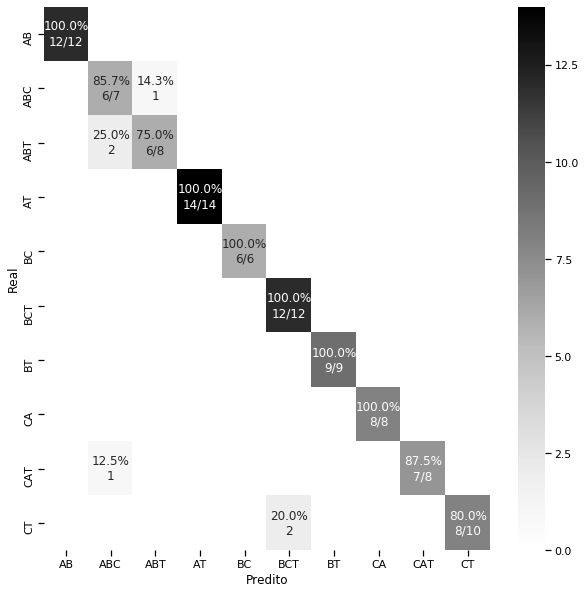

In [90]:
with open(model_path + 'rf_1_ciclo.pkl','rb') as f:
    rf_1_ciclo = pickle.load(f)
y_pred_1_ciclo = rf_1_ciclo.predict(X_te_1_ciclo)
cm_analysis(y_te_1_ciclo.values, y_pred_1_ciclo, 'cm_rf_1_ciclo.eps', rf_1_ciclo.classes_, figsize=(10,10))

In [0]:
X_tr_1_2_ciclo, X_te_1_2_ciclo, y_tr_1_2_ciclo, y_te_1_2_ciclo = train_test_split(data_1_2_ciclo.iloc[:,:576], data_1_2_ciclo.iloc[:,-1], test_size=0.1)
X_tr_1_2_ciclo, X_val_1_2_ciclo, y_tr_1_2_ciclo, y_val_1_2_ciclo = train_test_split(X_tr_1_2_ciclo, y_tr_1_2_ciclo, test_size=0.1105)

In [92]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True)
scores = []
final_scores = []
past_score = 0
for train, test in kf.split(X_tr_1_2_ciclo, y_tr_1_2_ciclo):
    for i in range(100):
        rf = RandomForestClassifier(n_estimators = 50, max_depth = 40, min_samples_split = 2, max_features = 'auto',
                                    min_samples_leaf = 1, bootstrap = False, criterion = 'entropy')
        rf.fit(X_tr_1_2_ciclo, y_tr_1_2_ciclo)
        y_pred_1_2_ciclo = rf.predict(X_val_1_2_ciclo)
        score = accuracy_score(y_pred_1_2_ciclo, y_val_1_2_ciclo)
        scores.append(score)
        if score > past_score:
            print(f'A acurácia atual é {100 * score:.2f}, a acurácia passada era {100 * past_score:.2f}.')
            with open(model_path + 'rf_1_2_ciclo.pkl','wb') as f:
                pickle.dump(rf, f)
            past_score = score
    final_scores.append(sum(scores)/len(scores))

A acurácia atual é 93.62, a acurácia passada era 0.00.
A acurácia atual é 95.74, a acurácia passada era 93.62.
A acurácia atual é 96.81, a acurácia passada era 95.74.
A acurácia atual é 97.87, a acurácia passada era 96.81.
CPU times: user 51min 25s, sys: 465 ms, total: 51min 26s
Wall time: 51min 28s


In [93]:
final_scores = np.array(final_scores)
print(f'\nMédia da acurácia: {np.mean(final_scores) * 100:.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores) * 100:.2f}%)')


Média da acurácia: 94.66%
Desvio padrão da acurácia: 0.02%)


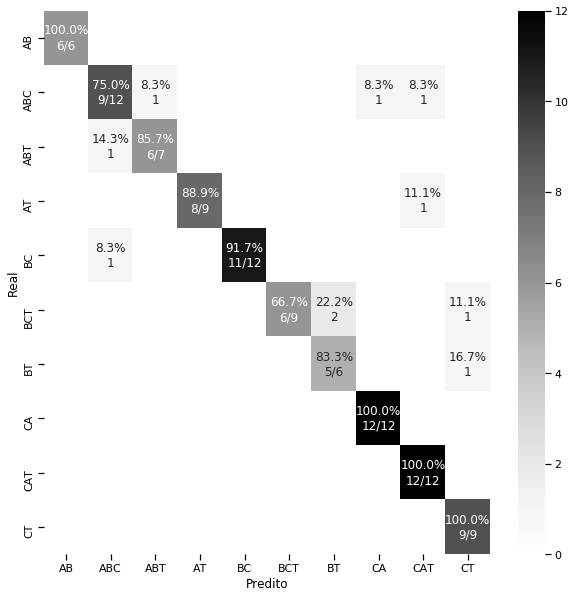

In [94]:
with open(model_path + 'rf_1_2_ciclo.pkl','rb') as f:
    rf_1_2_ciclo = pickle.load(f)
y_pred_1_2_ciclo = rf_1_2_ciclo.predict(X_te_1_2_ciclo)
cm_analysis(y_te_1_2_ciclo.values, y_pred_1_2_ciclo, 'cm_rf_1_2_ciclo.eps', rf_1_2_ciclo.classes_, figsize=(10,10))

In [0]:
X_tr_1_4_ciclo, X_te_1_4_ciclo, y_tr_1_4_ciclo, y_te_1_4_ciclo = train_test_split(data_1_4_ciclo.iloc[:,:384], data_1_4_ciclo.iloc[:,-1], test_size=0.1)
X_tr_1_4_ciclo, X_val_1_4_ciclo, y_tr_1_4_ciclo, y_val_1_4_ciclo = train_test_split(X_tr_1_4_ciclo, y_tr_1_4_ciclo, test_size=0.1105)

In [96]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True)
scores = []
final_scores = []
past_score = 0
for train, test in kf.split(X_tr_1_4_ciclo, y_tr_1_4_ciclo):
    for i in range(100):
        rf = RandomForestClassifier(n_estimators = 50, max_depth = 40, min_samples_split = 2, max_features = 'auto',
                                    min_samples_leaf = 1, bootstrap = False, criterion = 'entropy')
        rf.fit(X_tr_1_4_ciclo, y_tr_1_4_ciclo)
        y_pred_1_4_ciclo = rf.predict(X_val_1_4_ciclo)
        score = accuracy_score(y_pred_1_4_ciclo, y_val_1_4_ciclo)
        scores.append(score)
        if score > past_score:
            print(f'A acurácia atual é {100 * score:.2f}, a acurácia passada era {100 * past_score:.2f}.')
            with open(model_path + 'rf_1_4_ciclo.pkl','wb') as f:
                pickle.dump(rf, f)
            past_score = score
    final_scores.append(sum(scores)/len(scores))

A acurácia atual é 98.94, a acurácia passada era 0.00.
CPU times: user 44min 21s, sys: 339 ms, total: 44min 21s
Wall time: 44min 23s


In [97]:
final_scores = np.array(final_scores)
print(f'\nMédia da acurácia: {np.mean(final_scores) * 100:.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores) * 100:.2f}%)')


Média da acurácia: 94.43%
Desvio padrão da acurácia: 0.06%)


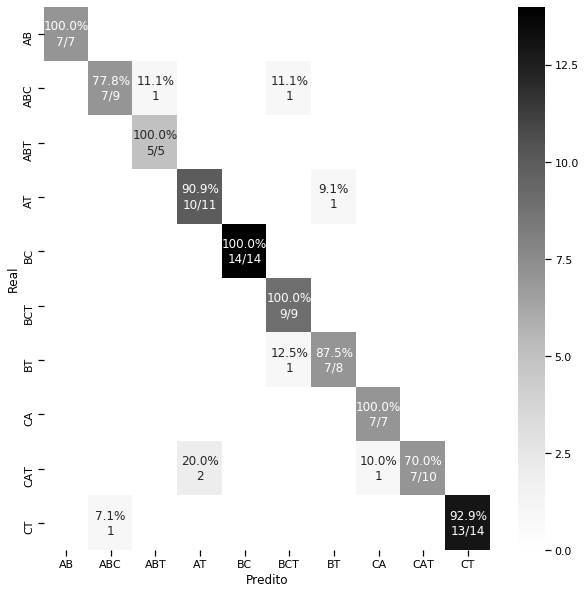

In [98]:
with open(model_path + 'rf_1_4_ciclo.pkl','rb') as f:
    rf_1_4_ciclo = pickle.load(f)
y_pred_1_4_ciclo = rf_1_4_ciclo.predict(X_te_1_4_ciclo)
cm_analysis(y_te_1_4_ciclo.values, y_pred_1_4_ciclo, 'cm_rf_1_4_ciclo.eps', rf_1_4_ciclo.classes_, figsize=(10,10))

In [0]:
X_tr_1_8_ciclo, X_te_1_8_ciclo, y_tr_1_8_ciclo, y_te_1_8_ciclo = train_test_split(data_1_8_ciclo.iloc[:,:288], data_1_8_ciclo.iloc[:,-1], test_size=0.1)
X_tr_1_8_ciclo, X_val_1_8_ciclo, y_tr_1_8_ciclo, y_val_1_8_ciclo = train_test_split(X_tr_1_8_ciclo, y_tr_1_8_ciclo, test_size=0.1105)

In [100]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True)
scores = []
final_scores = []
past_score = 0
for train, test in kf.split(X_tr_1_8_ciclo, y_tr_1_8_ciclo):
    for i in range(100):
        rf = RandomForestClassifier(n_estimators = 50, max_depth = 40, min_samples_split = 2, max_features = 'auto',
                                    min_samples_leaf = 1, bootstrap = False, criterion = 'entropy')
        rf.fit(X_tr_1_8_ciclo, y_tr_1_8_ciclo)
        y_pred_1_8_ciclo = rf.predict(X_val_1_8_ciclo)
        score = accuracy_score(y_pred_1_8_ciclo, y_val_1_8_ciclo)
        scores.append(score)
        if score > past_score:
            print(f'A acurácia atual é {100 * score:.2f}, a acurácia passada era {100 * past_score:.2f}.')
            with open(model_path + 'rf_1_8_ciclo.pkl','wb') as f:
                pickle.dump(rf, f)
            past_score = score
    final_scores.append(sum(scores)/len(scores))

A acurácia atual é 90.43, a acurácia passada era 0.00.
A acurácia atual é 96.81, a acurácia passada era 90.43.
A acurácia atual é 98.94, a acurácia passada era 96.81.
CPU times: user 38min 15s, sys: 347 ms, total: 38min 15s
Wall time: 38min 16s


In [101]:
final_scores = np.array(final_scores)
print(f'\nMédia da acurácia: {np.mean(final_scores) * 100:.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores) * 100:.2f}%)')


Média da acurácia: 92.05%
Desvio padrão da acurácia: 0.07%)


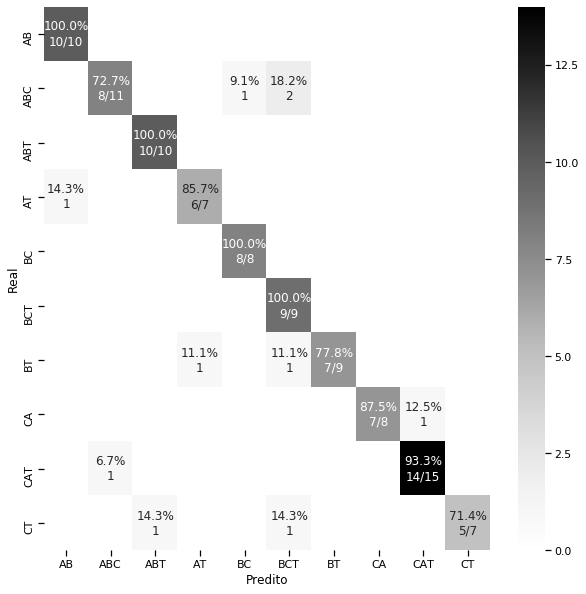

In [102]:
with open(model_path + 'rf_1_8_ciclo.pkl','rb') as f:
    rf_1_8_ciclo = pickle.load(f)
y_pred_1_8_ciclo = rf_1_8_ciclo.predict(X_te_1_8_ciclo)
cm_analysis(y_te_1_8_ciclo.values, y_pred_1_8_ciclo, 'cm_rf_1_8_ciclo.eps', rf_1_8_ciclo.classes_, figsize=(10,10))

In [0]:
X_tr_1_16_ciclo, X_te_1_16_ciclo, y_tr_1_16_ciclo, y_te_1_16_ciclo = train_test_split(data_1_16_ciclo.iloc[:,:240], data_1_16_ciclo.iloc[:,-1], test_size=0.1)
X_tr_1_16_ciclo, X_val_1_16_ciclo, y_tr_1_16_ciclo, y_val_1_16_ciclo = train_test_split(X_tr_1_16_ciclo, y_tr_1_16_ciclo, test_size=0.1105)

In [104]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True)
scores = []
final_scores = []
past_score = 0
for train, test in kf.split(X_tr_1_16_ciclo, y_tr_1_16_ciclo):
    for i in range(100):
        rf = RandomForestClassifier(n_estimators = 50, max_depth = 40, min_samples_split = 2, max_features = 'auto',
                                    min_samples_leaf = 1, bootstrap = False, criterion = 'entropy')
        rf.fit(X_tr_1_16_ciclo, y_tr_1_16_ciclo)
        y_pred_1_16_ciclo = rf.predict(X_val_1_16_ciclo)
        score = accuracy_score(y_pred_1_16_ciclo, y_val_1_16_ciclo)
        scores.append(score)
        if score > past_score:
            print(f'A acurácia atual é {100 * score:.2f}, a acurácia passada era {100 * past_score:.2f}.')
            with open(model_path + 'rf_1_16_ciclo.pkl','wb') as f:
                pickle.dump(rf, f)
            past_score = score
    final_scores.append(sum(scores)/len(scores))

A acurácia atual é 91.49, a acurácia passada era 0.00.
A acurácia atual é 92.55, a acurácia passada era 91.49.
A acurácia atual é 93.62, a acurácia passada era 92.55.
A acurácia atual é 94.68, a acurácia passada era 93.62.
A acurácia atual é 95.74, a acurácia passada era 94.68.
A acurácia atual é 96.81, a acurácia passada era 95.74.
CPU times: user 34min, sys: 305 ms, total: 34min 1s
Wall time: 34min 2s


In [105]:
final_scores = np.array(final_scores)
print(f'\nMédia da acurácia: {np.mean(final_scores) * 100:.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores) * 100:.2f}%)')


Média da acurácia: 90.93%
Desvio padrão da acurácia: 0.04%)


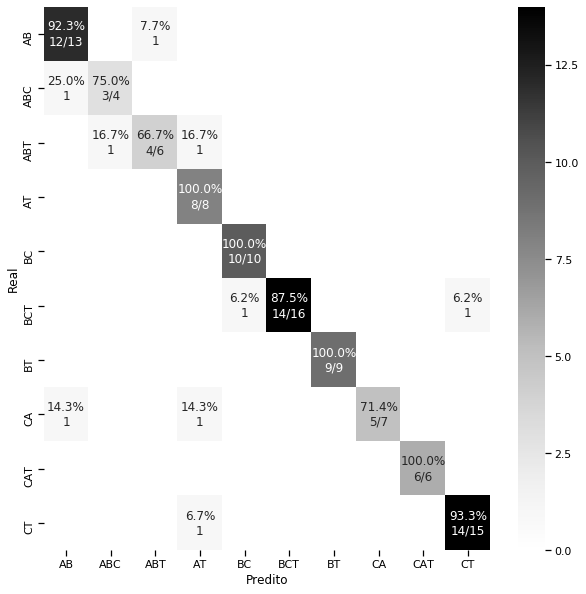

In [106]:
with open(model_path + 'rf_1_16_ciclo.pkl','rb') as f:
    rf_1_16_ciclo = pickle.load(f)
y_pred_1_16_ciclo = rf_1_16_ciclo.predict(X_te_1_16_ciclo)
cm_analysis(y_te_1_16_ciclo.values, y_pred_1_16_ciclo, 'cm_rf_1_16_ciclo.eps', rf_1_16_ciclo.classes_, figsize=(10,10))

In [0]:
X_tr_1_32_ciclo, X_te_1_32_ciclo, y_tr_1_32_ciclo, y_te_1_32_ciclo = train_test_split(data_1_32_ciclo.iloc[:,:216], data_1_32_ciclo.iloc[:,-1], test_size=0.1)
X_tr_1_32_ciclo, X_val_1_32_ciclo, y_tr_1_32_ciclo, y_val_1_32_ciclo = train_test_split(X_tr_1_32_ciclo, y_tr_1_32_ciclo, test_size=0.1105)

In [108]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True)
scores = []
final_scores = []
past_score = 0
for train, test in kf.split(X_tr_1_32_ciclo, y_tr_1_32_ciclo):
    for i in range(100):
        rf = RandomForestClassifier(n_estimators = 50, max_depth = 40, min_samples_split = 2, max_features = 'auto',
                                    min_samples_leaf = 1, bootstrap = False, criterion = 'entropy')
        rf.fit(X_tr_1_32_ciclo, y_tr_1_32_ciclo)
        y_pred_1_32_ciclo = rf.predict(X_val_1_32_ciclo)
        score = accuracy_score(y_pred_1_32_ciclo, y_val_1_32_ciclo)
        scores.append(score)
        if score > past_score:
            print(f'A acurácia atual é {100 * score:.2f}, a acurácia passada era {100 * past_score:.2f}.')
            with open(model_path + 'rf_1_32_ciclo.pkl','wb') as f:
                pickle.dump(rf, f)
            past_score = score
    final_scores.append(sum(scores)/len(scores))

A acurácia atual é 85.11, a acurácia passada era 0.00.
A acurácia atual é 88.30, a acurácia passada era 85.11.
A acurácia atual é 90.43, a acurácia passada era 88.30.
A acurácia atual é 91.49, a acurácia passada era 90.43.
A acurácia atual é 92.55, a acurácia passada era 91.49.
CPU times: user 33min 41s, sys: 361 ms, total: 33min 41s
Wall time: 33min 43s


In [109]:
final_scores = np.array(final_scores)
print(f'\nMédia da acurácia: {np.mean(final_scores) * 100:.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores) * 100:.2f}%)')


Média da acurácia: 86.99%
Desvio padrão da acurácia: 0.07%)


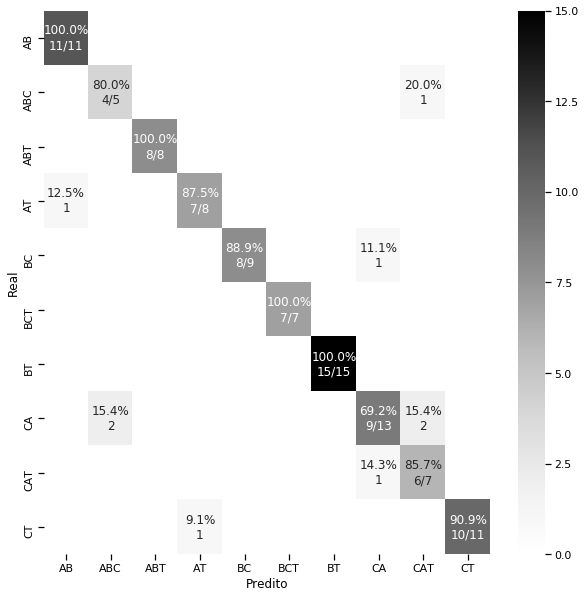

In [110]:
with open(model_path + 'rf_1_32_ciclo.pkl','rb') as f:
    rf_1_32_ciclo = pickle.load(f)
y_pred_1_32_ciclo = rf_1_32_ciclo.predict(X_te_1_32_ciclo)
cm_analysis(y_te_1_32_ciclo.values, y_pred_1_32_ciclo, 'cm_rf_1_32_ciclo.eps', rf_1_32_ciclo.classes_, figsize=(10,10))

In [0]:
import scipy.io
from os import listdir
from os.path import isfile, join
from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from numpy import genfromtxt
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
  # Function by hitvoice
  # https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
  """
  Generate matrix plot of confusion matrix with pretty annotations.
  The plot image is saved to disk.
  args: 
  y_true:    true label of the data, with shape (nsamples,)
  y_pred:    prediction of the data, with shape (nsamples,)
  filename:  filename of figure file to save
  labels:    string array, name the order of class labels in the confusion matrix.
             use `clf.classes_` if using scikit-learn models.
             with shape (nclass,).
  ymap:      dict: any -> string, length == nclass.
             if not None, map the labels & ys to more understandable strings.
             Caution: original y_true, y_pred and labels must align.
  figsize:   the size of the figure plotted.
  """
  if ymap is not None:
    y_pred = [ymap[yi] for yi in y_pred]
    y_true = [ymap[yi] for yi in y_true]
    labels = [ymap[yi] for yi in labels]
  cm = confusion_matrix(y_true, y_pred, labels=labels)
  cm_sum = np.sum(cm, axis=1, keepdims=True)
  cm_perc = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape
  for i in range(nrows):
      for j in range(ncols):
          c = cm[i, j]
          p = cm_perc[i, j]
          if i == j:
              s = cm_sum[i]
              annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
          elif c == 0:
              annot[i, j] = ''
          else:
              annot[i, j] = '%.1f%%\n%d' % (p, c)
  cm = pd.DataFrame(cm, index=labels, columns=labels)
  cm.index.name = 'Real'
  cm.columns.name = 'Predito'
  fig, ax = plt.subplots(figsize=figsize)
  sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='Greys')
  plt.savefig(filename, dpi=300)


In [0]:
X = genfromtxt(root_path + 'features3.csv', delimiter=',')
y = genfromtxt(root_path + 'target3.csv', delimiter=',', dtype='<U3')

In [0]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1105)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(751, 384)
(94, 384)
(94, 384)


In [0]:
kf = StratifiedKFold(n_splits=10, shuffle=True)
for train, test in kf.split(X, y):
    print(train.shape)
    print(test.shape)
    print('==='*10)


(839,)
(100,)
(839,)
(100,)
(839,)
(100,)
(840,)
(99,)
(849,)
(90,)
(849,)
(90,)
(849,)
(90,)
(849,)
(90,)
(849,)
(90,)
(849,)
(90,)


In [0]:
kf = StratifiedKFold(n_splits=10, shuffle=True)
scores = []
final_scores = []

for train, test in kf.split(X_train, y_train):
  for i in range(10):
    rf = RandomForestClassifier(n_estimators = 70, max_depth = 20, min_samples_split = 5,
                                min_samples_leaf = 1, bootstrap = False, criterion = 'entropy')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    scores.append(accuracy_score(y_pred, y_val))
  final_scores.append(sum(scores)/len(scores))
  s = pickle.dumps(rf)

final_scores = np.array(final_scores)
print(f'Acurácia média para cada fold repetido 10 vezes:\n {np.round(final_scores * 100, decimals=2)}')
print(f'\nMédia da acurácia: {np.mean(final_scores) * 100:.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores) * 100:.2f}%)')

Acurácia média para cada fold repetido 10 vezes:
 [96.06 96.28 96.21 96.17 96.3  96.24 96.29 96.3  96.3  96.31]

Média da acurácia: 96.25%
Desvio padrão da acurácia: 0.08%)


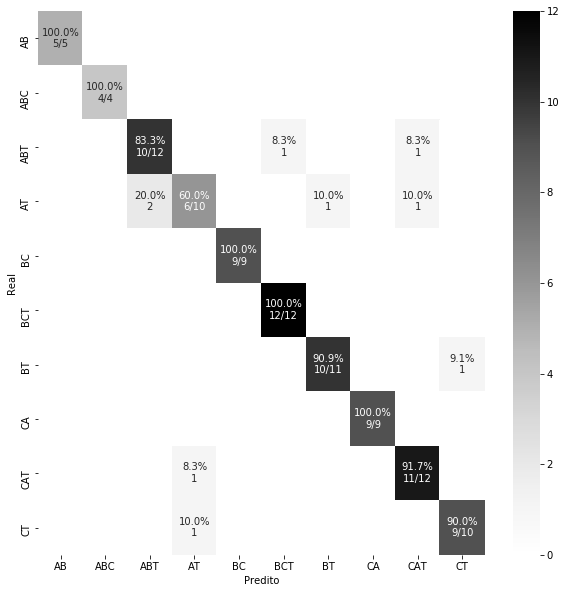

In [0]:
rf_model = pickle.loads(s)
y_pred = rf_model.predict(X_test)
cm_analysis(y_test, y_pred, 'cm_rf.eps', rf.classes_, figsize=(10,10))

# Rede MLP

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adagrad
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
label_encoder = LabelEncoder()
label_encoder.fit(y.ravel())
y_train_integer = label_encoder.fit_transform(y_train.ravel())
y_test_integer = label_encoder.fit_transform(y_test.ravel())
y_val_integer = label_encoder.fit_transform(y_val.ravel())

In [0]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = onehot_encoder.fit_transform(y_train_integer.reshape(len(y_train_integer), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test_integer.reshape(len(y_test_integer), 1))
y_val_onehot = onehot_encoder.fit_transform(y_val_integer.reshape(len(y_val_integer), 1))

In [0]:
# Use scikit-learn to grid search the number of neurons
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(neurons=1):
  init = initializers.glorot_normal()
  model = Sequential()
  model.add(Dense(384, activation = 'relu', input_dim = X_train.shape[1],
                  kernel_initializer = init, bias_initializer = init))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation = 'softmax', 
                  kernel_initializer = init, bias_initializer = init))
  opt = Adagrad(lr=0.01, epsilon=None, decay=0.0)
  model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=1000, batch_size=50, verbose=1)
# define the grid search parameters
neurons = [100, 200, 384, 500]
param_grid = dict(neurons=neurons)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=10, random_state=seed)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [0]:
init = initializers.glorot_normal()
model = Sequential()
model.add(Dense(384, activation = 'relu', input_dim = X_train.shape[1],
                kernel_initializer = init, bias_initializer = init))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax', 
                kernel_initializer = init, bias_initializer = init))
opt = Adagrad(lr=0.01, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose=1, patience=50)
history = model.fit(X_train, y_train_onehot, validation_data = (X_val, y_val_onehot), shuffle=True, batch_size = 50, 
          epochs = 5000, verbose = 1, callbacks=[stop])

W0825 02:07:54.107620 139640013043584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 02:07:54.127048 139640013043584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 02:07:54.132695 139640013043584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0825 02:07:54.148613 139640013043584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0825 02:07

Train on 751 samples, validate on 94 samples
Epoch 1/5000
751/751 [==============================] - 1s 2ms/step - loss: 1.9897 - acc: 0.3356 - val_loss: 1.7575 - val_acc: 0.3617
Epoch 2/5000
751/751 [==============================] - 0s 66us/step - loss: 1.4716 - acc: 0.5260 - val_loss: 1.4299 - val_acc: 0.4255
Epoch 3/5000
751/751 [==============================] - 0s 62us/step - loss: 1.2641 - acc: 0.5792 - val_loss: 1.3580 - val_acc: 0.4681
Epoch 4/5000
751/751 [==============================] - 0s 60us/step - loss: 1.1451 - acc: 0.6218 - val_loss: 1.2153 - val_acc: 0.6170
Epoch 5/5000
751/751 [==============================] - 0s 64us/step - loss: 1.0396 - acc: 0.6951 - val_loss: 1.2331 - val_acc: 0.4894
Epoch 6/5000
751/751 [==============================] - 0s 62us/step - loss: 0.9699 - acc: 0.6911 - val_loss: 1.0546 - val_acc: 0.6489
Epoch 7/5000
751/751 [==============================] - 0s 94us/step - loss: 0.9071 - acc: 0.7270 - val_loss: 1.0260 - val_acc: 0.7128
Epoch 8/500

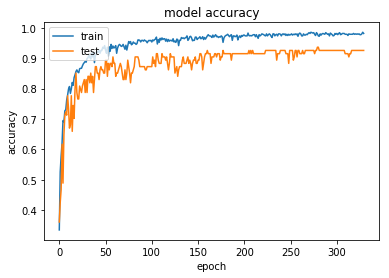

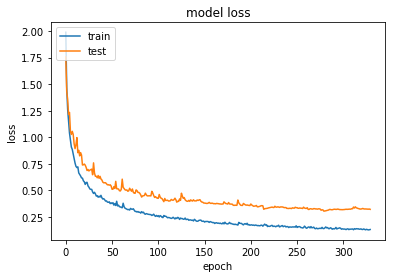

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('modelaccuracy.eps')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('modelloss.eps')
plt.show()

In [0]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)
cvscores = []
final_scores_mlp = []
for train, test in kfold.split(X_train, y_train_integer):
  for i in range(10):
    init = initializers.glorot_normal(seed=None)
    model = Sequential()
    model.add(Dense(384, activation='relu', input_dim = X_train.shape[1],
                    kernel_initializer = init, bias_initializer = init))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation = 'softmax', 
                    kernel_initializer = init, bias_initializer = init))
    opt = Adagrad(lr=0.01, epsilon=None, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
    stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose=1, patience=50)
    filepath = root_path + 'best_model_24_08.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    history = model.fit(X_train, y_train_onehot, validation_split = 0.1, shuffle=True, batch_size = 50, 
                        epochs = 5000, verbose = 0, callbacks=[stop, checkpoint])
    scores = model.evaluate(X_test, y_test_onehot, verbose=0)
    cvscores.append(scores[1] * 100)
  final_scores_mlp.append(sum(cvscores)/len(cvscores))
  
final_scores_mlp = np.array(final_scores_mlp)
print(f'Acurácia média para cada fold repetido 10 vezes: {np.round(final_scores_mlp, decimals=2)}')
print(f'\nMédia da acurácia: {np.mean(final_scores_mlp):.2f}%')
print(f'Desvio padrão da acurácia: {np.std(final_scores_mlp):.2f}%)')

Epoch 00399: early stopping
Epoch 00576: early stopping
Epoch 00166: early stopping
Epoch 00445: early stopping
Epoch 00272: early stopping
Epoch 00582: early stopping
Epoch 00653: early stopping
Epoch 00192: early stopping
Epoch 00416: early stopping
Epoch 00447: early stopping
Epoch 00553: early stopping
Epoch 00314: early stopping
Epoch 00879: early stopping
Epoch 00304: early stopping
Epoch 00368: early stopping
Epoch 00746: early stopping
Epoch 00639: early stopping
Epoch 00552: early stopping
Epoch 00417: early stopping
Epoch 00412: early stopping
Epoch 00506: early stopping
Epoch 00632: early stopping
Epoch 00653: early stopping
Epoch 00560: early stopping
Epoch 00530: early stopping
Epoch 00640: early stopping
Epoch 00524: early stopping
Epoch 00513: early stopping
Epoch 00593: early stopping
Epoch 00281: early stopping
Epoch 00314: early stopping
Epoch 00489: early stopping
Epoch 00608: early stopping
Epoch 00332: early stopping
Epoch 00620: early stopping
Epoch 00703: early s

## Best MLP model

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adagrad
from keras.utils import to_categorical
from keras.models import load_model

In [0]:
label_encoder = LabelEncoder()
label_encoder.fit(y.ravel())
y_train_integer = label_encoder.fit_transform(y_train.ravel())
y_test_integer = label_encoder.fit_transform(y_test.ravel())

onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = onehot_encoder.fit_transform(y_train_integer.reshape(len(y_train_integer), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test_integer.reshape(len(y_test_integer), 1))

In [0]:
best_model = load_model(root_path + 'best_model_24_08.h5')

In [0]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_201 (Dense)            (None, 384)               98688     
_________________________________________________________________
dropout_101 (Dropout)        (None, 384)               0         
_________________________________________________________________
dense_202 (Dense)            (None, 10)                3850      
Total params: 102,538
Trainable params: 102,538
Non-trainable params: 0
_________________________________________________________________


In [0]:
y_pred = best_model.predict(X_test)

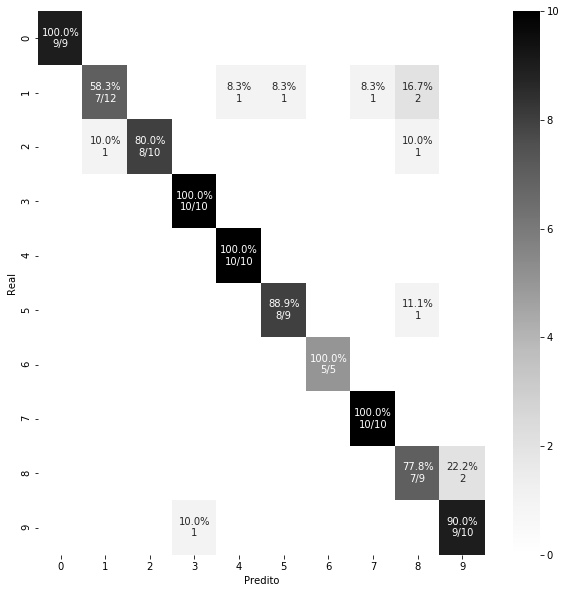

In [0]:
cm_analysis(y_test_onehot.argmax(axis=1), y_pred.argmax(axis=1), 'cm_mlp.eps', np.unique(y_test_onehot.argmax(axis=1)), figsize=(10,10))

In [0]:
'CT=9, AT=3, BC=4, ABT=2, AB=0, BCT=5, BT=6, CA=7, ABC=1, CAT=8'

'CT=9, AT=3, BC=4, ABT=2, AB=0, BCT=5, BT=6, CA=7, ABC=1, CAT=8'